In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats as ss

np.random.seed(seed=0)

Note: we train a calibration model on the training set (which is proper for this simple example).

We evaluate the calibrated model on the validation set.

In [2]:
#Simple 1D regression problem
train_x = (np.random.rand(1000)-0.5)*2
val_x = (np.random.rand(500)-0.5)*2
train_y = np.sin(4*train_x)
val_y = np.sin(4*val_x)
#Generate data with Laplace Noise

for i in range(len(train_x)):
    train_y[i] += np.sqrt(4.0*(np.abs((train_x[i]))))*np.random.laplace()
for i in range(len(val_x)):
    val_y[i] += np.sqrt(4.0*(np.abs((val_x[i]))))*np.random.laplace()
    
train_x = train_x.reshape(len(train_x), 1)
train_y = train_y.reshape(len(train_y), 1)

val_x = val_x.reshape(len(val_x), 1)
val_y = val_y.reshape(len(val_y), 1)


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

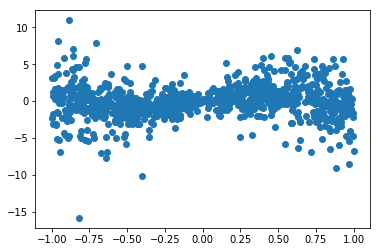

In [4]:
#plot training data
plt.scatter(train_x,train_y)
plt.show()

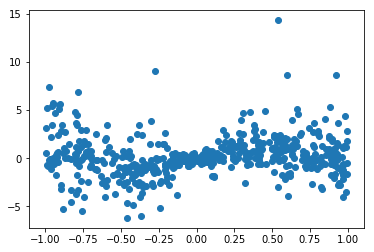

In [5]:
#plot testing data
plt.scatter(val_x,val_y)
plt.show()

In [6]:
#Build the model

x = tf.placeholder(tf.float32, shape = [None , 1]) 
y = tf.placeholder(tf.float32, shape = [None, 1])   

hidden = tf.layers.dense(x, 16, tf.nn.relu)
hidden1 = tf.layers.dense(hidden, 16, tf.nn.relu)
mean = tf.layers.dense(hidden1, 1)


hiddenlog = tf.layers.dense(x, 16, tf.nn.relu)
hiddenlog1 = tf.layers.dense(hiddenlog, 16, tf.nn.relu)
log_std = tf.layers.dense(hiddenlog1, 1)

loss = tf.reduce_mean(( tf.pow(tf.add(y, -mean), 2)/(1.0*tf.exp(log_std)) + 0.5*log_std))

optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

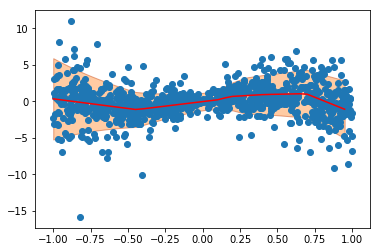

In [11]:
init = tf.global_variables_initializer() 
with tf.Session() as sess:
    sess.run(init)
    for i in range(100):
        cost,_ = sess.run([loss, optimizer], feed_dict={x: train_x, y: train_y})
        #print cost
    #plt.scatter(train_x, sess.run(mean, feed_dict={x : train_x}))
    
    y_pred_train, y_std_train= sess.run([mean, log_std], feed_dict={x: train_x})
    y_std_train = np.sqrt(np.exp(y_std_train))
    
    y_pred_val, y_std_val= sess.run([mean, log_std], feed_dict={x: val_x})
    y_std_val = np.sqrt(np.exp(y_std_val))
    
    #These data is generated for visualization purpose only
    test_x = np.arange(-1.0, 1.0, 0.05)
    test_x = test_x.reshape(len(test_x), 1)
    pred_mean, pred_std= sess.run([mean, log_std], feed_dict={x: test_x})
    stand = np.sqrt(np.exp(pred_std))
    plt.plot(test_x, pred_mean, color= 'red')
    plt.fill_between(test_x.flatten(),(pred_mean + 1.0*stand).flatten(), (pred_mean - 1.0*stand).flatten(),alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    #plt.show()
    plt.scatter(train_x, train_y)

# Calibration, we assume that the noise is Gaussian while in fact it is Laplacian Noise

In [12]:
# First, we plot the reliability diagram under Gaussian assumption on validation data:
# We only need 3 variables: y_pred, y_std and train_y

T = len(val_y)
gauss_expected = []

for i in range(T):
    gauss_expected.append(ss.norm.cdf(val_y[i], y_pred_val[i], y_std_val[i]))

interval = np.arange(11)*0.1

gauss_actual = []
for inter in interval:
    c = 0
    for i in gauss_expected:
        if i <= inter:
            c += 1
    gauss_actual.append(c/float(T))

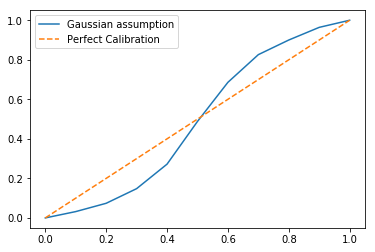

In [13]:
plt.plot(interval, gauss_actual, label = 'Gaussian assumption')
plt.plot(interval, interval, linestyle = '--', label = 'Perfect Calibration')
plt.legend()

In [17]:
# calibrate the model using Isotonic Regression
from sklearn.isotonic import IsotonicRegression

# Use calibration feature, the effect is similar

# First we build the dataset for calibration model
calib_feature = (train_y - y_pred_train)/y_std_train
calib_label = []
T_train = len(train_y)
for i in range(T_train):
    calib_label.append((calib_feature<calib_feature[i]).sum()/float(T_train)) #building the label
calib_label = np.array(calib_label)



In [18]:
# train a calibration model:
IR = IsotonicRegression()
IR.fit(calib_feature.flatten(), calib_label.flatten())

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None,
          y_min=None)

In [19]:
calib_feature_validation = (val_y - y_pred_val)/y_std_val

calibrated_interval = IR.transform(calib_feature_validation.flatten())

In [23]:
#plot reliability diagram
actual_interval = []
for inter in interval:
    c = 0
    for i in calibrated_interval:
        if i <= inter:
            c += 1
    actual_interval.append(c/float(T))

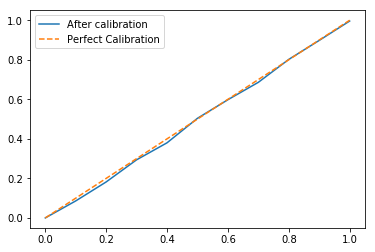

In [24]:
plt.plot(interval, actual_interval, label = 'After calibration')
plt.plot(interval, interval, linestyle = '--', label = 'Perfect Calibration')
plt.legend()